Calcul du nombre de neurones pathologiques dans le reseau

Temps estimé: 33 min

In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import os
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import gpustat

#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 3

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

'''
#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))'''

setGPU: Setting GPU to: 3


'\n#set memory usage to 0.5\nfrom keras.backend.tensorflow_backend import set_session\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.5\nset_session(tf.Session(config=config))'

In [3]:
#!pip install -q sklearn
#!pip install --upgrade pip
import collections
import numpy as np, numpy
from keract import get_activations, display_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10, cifar100 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import sys
#sys.executable
#sys.path
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
def normalize(x, mean, std):
    # This function normalizes inputs for zero mean and unit variance to speed up learning.
    
    # In case std = 0, we add eps = 1e-7
    eps = K.epsilon()
    x = (x-mean)/(std+eps)
    return x
  
def import_cifar(dataset):
    if dataset == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    elif dataset == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # By default, they are uint8 but we need them float to normalize them
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Calculating the mean and standard deviation of the training data
    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    
    # Normalizing 
    x_train = normalize(x_train, mean, std)
    x_test = normalize(x_test, mean, std)

    y_train = to_categorical(y_train, num_classes=dataset)
    y_test = to_categorical(y_test,  num_classes=dataset)
    
    return (x_train, y_train), (x_test, y_test)

In [5]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [6]:
# Architecture taken from https://github.com/geifmany/cifar-vgg
# Weight decay and Dropout have been removed
# BatchNormalization before activations
def VGG16_Vanilla_beta(input_shape, num_classes):
    model = Sequential([
        #0
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #3
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #7
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #10
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #14
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #17
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #20
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #24
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #27
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #30
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #34
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #37
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #40
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        #45
        Dense(512),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #48
        Dense(num_classes),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')])
    return model

In [7]:
List_of_Pré_Activations = ['conv2d_1/BiasAdd:0','conv2d_2/BiasAdd:0','max_pooling2d_1/MaxPool:0','conv2d_3/BiasAdd:0', 'conv2d_4/BiasAdd:0','max_pooling2d_2/MaxPool:0','conv2d_5/BiasAdd:0', 'conv2d_6/BiasAdd:0','conv2d_7/BiasAdd:0', 'max_pooling2d_3/MaxPool:0','conv2d_8/BiasAdd:0', 'conv2d_9/BiasAdd:0','conv2d_10/BiasAdd:0', 'max_pooling2d_4/MaxPool:0','conv2d_11/BiasAdd:0', 'conv2d_12/BiasAdd:0','conv2d_13/BiasAdd:0', 'max_pooling2d_5/MaxPool:0','dense_1/BiasAdd:0', 'dense_2/BiasAdd:0']
List_of_Post_Activations = [    'activation_1/Relu:0','activation_2/Relu:0',    'activation_3/Relu:0','activation_4/Relu:0',    'activation_5/Relu:0','activation_6/Relu:0',    'activation_7/Relu:0','activation_8/Relu:0',    'activation_9/Relu:0','activation_10/Relu:0',    'activation_11/Relu:0','activation_12/Relu:0',    'activation_13/Relu:0','activation_14/Relu:0',    'activation_15/Softmax:0']

In [8]:
def PATH(IM, nameOfTheLayer):
    #count the number of pathologic neurons
    pathologicCount_0 = 0
    pathologicCount_1 = 0
    
    numNeurons = numpy.size(IM[nameOfTheLayer][0])
    #print('numNeurons : ', str(numNeurons)) # 65536 neurones
    #print('nombreDImagesDActivation : ', str(nombreDImagesDActivation)) # 100 images d'activations
    
    MatrixActivation = np.zeros((numNeurons,nombreDImagesDActivation))
    
    indexActi = -1
    for activation in IM[nameOfTheLayer]:   # on a les activations pour de la couche
        
        indexActi = indexActi + 1
        
        #print(len(activation)) # image_X
        #print(len(activation[0])) # image_Y
        #print(len(activation[0][0])) # les 64 filtres de la couche convolutive
        activation = activation.flatten() # on a tous nos neurones sur un seul vecteur
        
        for i in range(numNeurons):
            MatrixActivation[i,indexActi] = activation[i]

    #on normalise les activations
    MatrixActivation_normed = MatrixActivation / MatrixActivation.max(axis=0)
    
    #print(len(MatrixActivation_normed[:,0])) #nombre de neurones
    #print(len(MatrixActivation_normed[0,:])) # nombre d'activation
    
    for j in range(numNeurons):
        if all([ v == 0 for v in MatrixActivation_normed[j,:] ]):
            pathologicCount_0 = pathologicCount_0 + 1
        elif all([ v == 1 for v in MatrixActivation_normed[j,:] ]):
            pathologicCount_1 = pathologicCount_1 + 1

    return pathologicCount_0, pathologicCount_1, numNeurons


In [9]:
def RUN(IM, modelename):
    # initialization of variables for the plot of the pathologic count
    PRatio_0 = []
    PRatio_1 = []
    print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')

    print('\n Model  :\n')
    for layer in List_of_Post_Activations:
        #nom de la couche
        print('couche :', str(layer))
        pathologicCount_0, pathologicCount_1, numNeurons = PATH(IM, layer)
        PRatio_0.append(pathologicCount_0/numNeurons)
        PRatio_1.append(pathologicCount_1/numNeurons)
        print('  pathologic count: ', str((pathologicCount_0+pathologicCount_1)),' on ',str(numNeurons), ' = ', str((pathologicCount_0+pathologicCount_1)/numNeurons*100), '%')
        
    # plot:
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(10, 5))
    plt.ylim(top=0.35)
    nombreCouches = len(PRatio_0)
    x = range(nombreCouches)

    markerline, stemlines, baseline = plt.stem(x, PRatio_0, markerfmt='o', label='0 ')
    plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
    plt.setp(stemlines, 'linestyle', 'dotted')

    markerline, stemlines, baseline = plt.stem(x, PRatio_1, markerfmt='o', label='1 ')
    plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
    plt.setp(stemlines, 'linestyle', 'dotted')

    line0 = plt.plot(np.mean(PRatio_0)*np.ones((nombreCouches,1)))
    line1 = plt.plot(np.mean(PRatio_1)*np.ones((nombreCouches,1)))

    #plt.legend()
    #plt.xlabel('Layers')
    plt.xticks(np.arange(nombreCouches), ('Conv 1','Conv 2','Conv 3','Conv 4','Conv 5','Conv 6','Conv 7','Conv 8','Conv 9','Conv10','Conv11','Conv12','Conv13','Dense1','Dense2'), rotation=60)
    #plt.ylabel('Ratio')
    plt.grid()
    #plt.title('Ratio of pathological neurons by layer for the model '+modelename+'\n for '+str(nombreDImagesDActivation)+' activation images\n')
    plt.show()
    fig.savefig('figures/Pathologic/Pathologic_{}.png'.format(modelename), dpi=100)

In [10]:
# LOAD the model and get the activations
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/initial/weights-initial.hdf5'.format(modelename) #final / initial ! attention au nom de sauvegarde !
modelename = 'initial'
model = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10)
model.load_weights('{}'.format(model_name))
sgd = optimizers.SGD(lr=0.002, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# On regarde l'activation des pairs de neurones pour un echantillon test pris au hasard
Echantillon = []
nombreDImagesDActivation = 1000
NombrePairs = 10000
choix = np.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_train[choix, :, : , :]
IM = get_activations(model, Echantillon)# on affiche les noms des differentes couches
# on affiche les noms des differentes couches
#print(IM.keys())
#model.summary()
# Run the code
RUN(IM, modelename)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_3/Relu:0
  pathologic count:  2  on  32768  =  0.006103515625 %
couche : activation_4/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_5/Relu:0
  pathologic count:  9  on  16384  =  0.054931640625 %
couche : activation_6/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_7/Relu:0
  pathologic count:  1  on  16384  =  0.006103515625 %
couche : activation_8/Relu:0
  pathologic count:  9  on  8192  =  0.10986328125 %
couche : activation_9/Relu:0
  pathologic count:  4  on  8192  =  0.048828125 %
couche : activation_10/Relu:0
  pathologic count:  2  on  8192  =  0.0244140625 %
couche : activation_11/Relu:0
  pathologic count:  33  on  2048  =  1.611328125 %
couche : activation_12/Relu:0
  pathologic count:  56  on  2048 

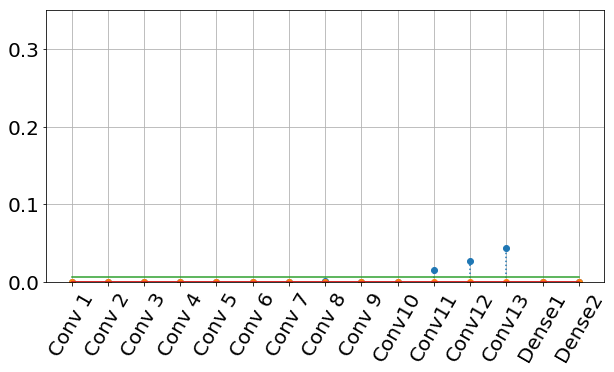

In [11]:
modelename = 'vgg16_layca_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_3/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_4/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_5/Relu:0
  pathologic count:  6  on  16384  =  0.03662109375 %
couche : activation_6/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_7/Relu:0
  pathologic count:  2  on  16384  =  0.01220703125 %
couche : activation_8/Relu:0
  pathologic count:  6  on  8192  =  0.0732421875 %
couche : activation_9/Relu:0
  pathologic count:  1  on  8192  =  0.01220703125 %
couche : activation_10/Relu:0
  pathologic count:  2  on  8192  =  0.0244140625 %
couche : activation_11/Relu:0
  pathologic count:  50  on  2048  =  2.44140625 %
couche : activation_12/Relu:0
  pathologic count:  53  on  2048  =  2.5878906

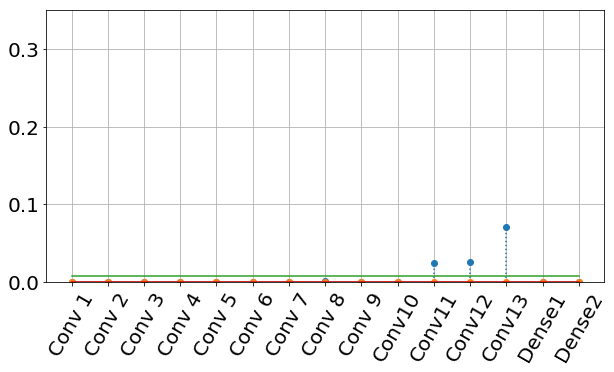

In [12]:
modelename = 'vgg16_layca_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_3/Relu:0
  pathologic count:  10  on  32768  =  0.030517578125 %
couche : activation_4/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_5/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_6/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_7/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_8/Relu:0
  pathologic count:  7  on  8192  =  0.08544921875 %
couche : activation_9/Relu:0
  pathologic count:  0  on  8192  =  0.0 %
couche : activation_10/Relu:0
  pathologic count:  0  on  8192  =  0.0 %
couche : activation_11/Relu:0
  pathologic count:  5  on  2048  =  0.244140625 %
couche : activation_12/Relu:0
  pathologic count:  0  on  2048  =  0.0 %
couche : activation_13/Relu:0


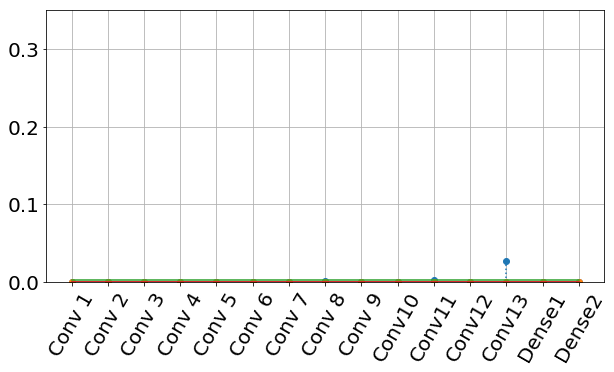

In [13]:
modelename = 'vgg16_layca_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  1  on  65536  =  0.00152587890625 %
couche : activation_3/Relu:0
  pathologic count:  4  on  32768  =  0.01220703125 %
couche : activation_4/Relu:0
  pathologic count:  1  on  32768  =  0.0030517578125 %
couche : activation_5/Relu:0
  pathologic count:  9  on  16384  =  0.054931640625 %
couche : activation_6/Relu:0
  pathologic count:  3  on  16384  =  0.018310546875 %
couche : activation_7/Relu:0
  pathologic count:  3  on  16384  =  0.018310546875 %
couche : activation_8/Relu:0
  pathologic count:  10  on  8192  =  0.1220703125 %
couche : activation_9/Relu:0
  pathologic count:  10  on  8192  =  0.1220703125 %
couche : activation_10/Relu:0
  pathologic count:  6  on  8192  =  0.0732421875 %
couche : activation_11/Relu:0
  pathologic count:  39  on  2048  =  1.904296875 %
couche : activation_12/Relu

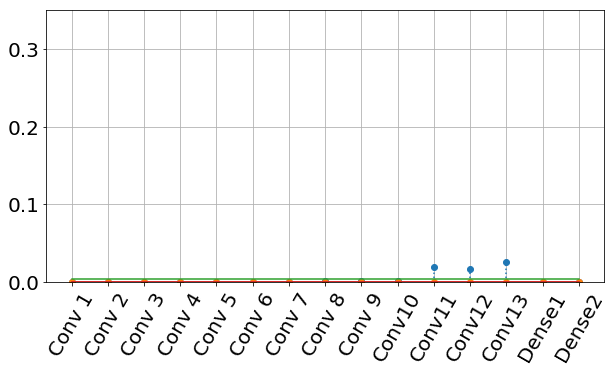

In [14]:
modelename = 'vgg16_sgd_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_3/Relu:0
  pathologic count:  1  on  32768  =  0.0030517578125 %
couche : activation_4/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_5/Relu:0
  pathologic count:  5  on  16384  =  0.030517578125 %
couche : activation_6/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_7/Relu:0
  pathologic count:  2  on  16384  =  0.01220703125 %
couche : activation_8/Relu:0
  pathologic count:  13  on  8192  =  0.15869140625 %
couche : activation_9/Relu:0
  pathologic count:  6  on  8192  =  0.0732421875 %
couche : activation_10/Relu:0
  pathologic count:  22  on  8192  =  0.2685546875 %
couche : activation_11/Relu:0
  pathologic count:  165  on  2048  =  8.056640625 %
couche : activation_12/Relu:0
  pathologic count:  233  on  

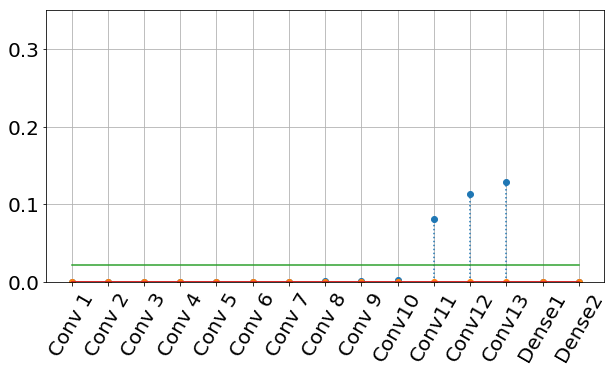

In [15]:
modelename = 'vgg16_sgd_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  6  on  65536  =  0.0091552734375 %
couche : activation_3/Relu:0
  pathologic count:  17  on  32768  =  0.0518798828125 %
couche : activation_4/Relu:0
  pathologic count:  1  on  32768  =  0.0030517578125 %
couche : activation_5/Relu:0
  pathologic count:  161  on  16384  =  0.982666015625 %
couche : activation_6/Relu:0
  pathologic count:  40  on  16384  =  0.244140625 %
couche : activation_7/Relu:0
  pathologic count:  40  on  16384  =  0.244140625 %
couche : activation_8/Relu:0
  pathologic count:  964  on  8192  =  11.767578125 %
couche : activation_9/Relu:0
  pathologic count:  755  on  8192  =  9.21630859375 %
couche : activation_10/Relu:0
  pathologic count:  552  on  8192  =  6.73828125 %
couche : activation_11/Relu:0
  pathologic count:  612  on  2048  =  29.8828125 %
couche : activation_12/R

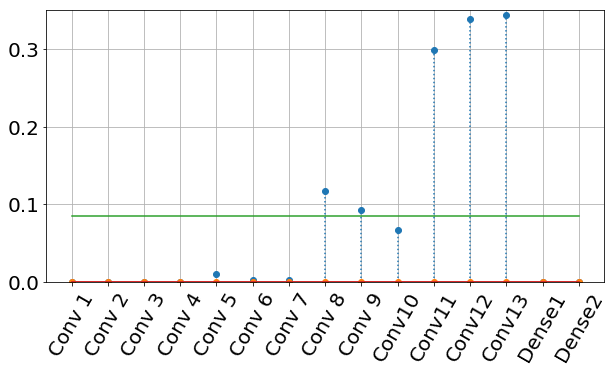

In [16]:
modelename = 'vgg16_sgd_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  1  on  65536  =  0.00152587890625 %
couche : activation_3/Relu:0
  pathologic count:  2  on  32768  =  0.006103515625 %
couche : activation_4/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_5/Relu:0
  pathologic count:  6  on  16384  =  0.03662109375 %
couche : activation_6/Relu:0
  pathologic count:  1  on  16384  =  0.006103515625 %
couche : activation_7/Relu:0
  pathologic count:  6  on  16384  =  0.03662109375 %
couche : activation_8/Relu:0
  pathologic count:  5  on  8192  =  0.06103515625 %
couche : activation_9/Relu:0
  pathologic count:  4  on  8192  =  0.048828125 %
couche : activation_10/Relu:0
  pathologic count:  7  on  8192  =  0.08544921875 %
couche : activation_11/Relu:0
  pathologic count:  37  on  2048  =  1.806640625 %
couche : activation_12/Relu:0
  pathologi

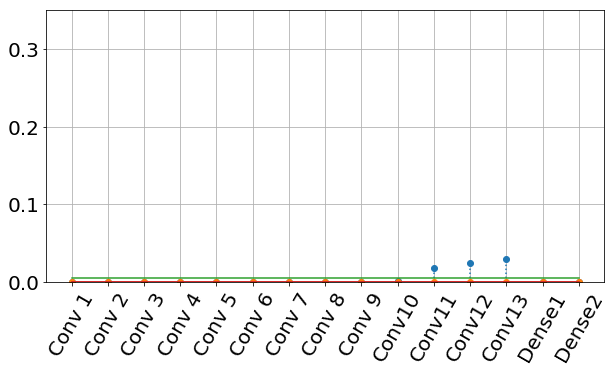

In [17]:
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  2  on  65536  =  0.0030517578125 %
couche : activation_3/Relu:0
  pathologic count:  3  on  32768  =  0.0091552734375 %
couche : activation_4/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_5/Relu:0
  pathologic count:  4  on  16384  =  0.0244140625 %
couche : activation_6/Relu:0
  pathologic count:  4  on  16384  =  0.0244140625 %
couche : activation_7/Relu:0
  pathologic count:  3  on  16384  =  0.018310546875 %
couche : activation_8/Relu:0
  pathologic count:  4  on  8192  =  0.048828125 %
couche : activation_9/Relu:0
  pathologic count:  6  on  8192  =  0.0732421875 %
couche : activation_10/Relu:0
  pathologic count:  14  on  8192  =  0.1708984375 %
couche : activation_11/Relu:0
  pathologic count:  131  on  2048  =  6.396484375 %
couche : activation_12/Relu:0
  pathologic 

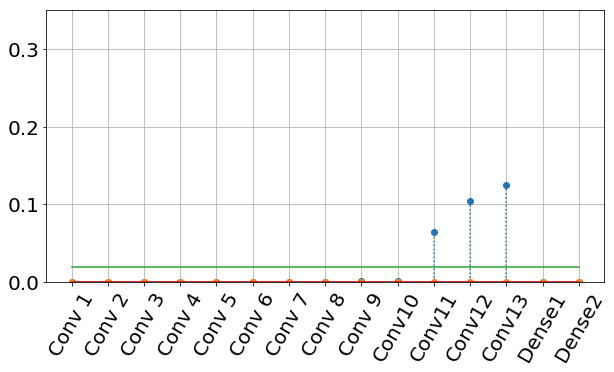

In [18]:
modelename = 'vgg16_wdecay_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)

number of images used for see the activations : 1000


 Model  :

couche : activation_1/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_2/Relu:0
  pathologic count:  0  on  65536  =  0.0 %
couche : activation_3/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_4/Relu:0
  pathologic count:  0  on  32768  =  0.0 %
couche : activation_5/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_6/Relu:0
  pathologic count:  1  on  16384  =  0.006103515625 %
couche : activation_7/Relu:0
  pathologic count:  0  on  16384  =  0.0 %
couche : activation_8/Relu:0
  pathologic count:  9  on  8192  =  0.10986328125 %
couche : activation_9/Relu:0
  pathologic count:  0  on  8192  =  0.0 %
couche : activation_10/Relu:0
  pathologic count:  0  on  8192  =  0.0 %
couche : activation_11/Relu:0
  pathologic count:  41  on  2048  =  2.001953125 %
couche : activation_12/Relu:0
  pathologic count:  14  on  2048  =  0.68359375 %
couche : activation_13

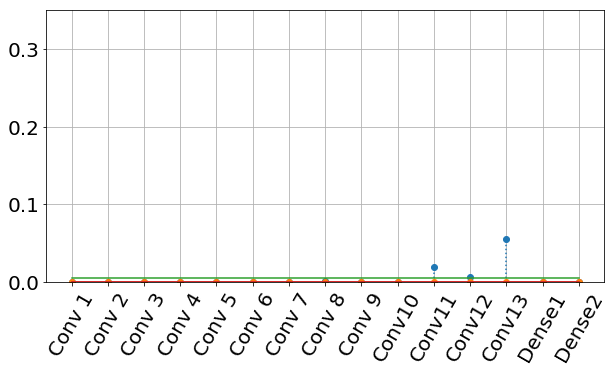

In [19]:
modelename = 'vgg16_wdecay_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename)